**Dependencies**

In [ ]:
from datetime import datetime
import pandas as pd
import json

from transformers import (
    AutoModel,
    AutoModelForMaskedLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    DataCollatorForWholeWordMask,
    Trainer,
    TrainingArguments,
)

import torch
from torch.nn.functional import cosine_similarity
from torch.utils.data import DataLoader
from collections import defaultdict


**Loading Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_users_pth = '/content/drive/MyDrive/Hybrid_Rec_Sys/data/MINDsmall_train/behaviors.tsv'
train_news_pth =  '/content/drive/MyDrive/Hybrid_Rec_Sys/data/MINDsmall_train/news.tsv'
dev_users_pth = '/content/drive/MyDrive/Hybrid_Rec_Sys/data/MINDsmall_dev/behaviors.tsv'
dev_news_pth = '/content/drive/MyDrive/Hybrid_Rec_Sys/data/MINDsmall_dev/news.tsv'


train_users = pd.read_csv(train_users_pth, delimiter='\t', header=None)
dev_users = pd.read_csv(dev_users_pth, delimiter='\t', header=None)
news = pd.read_csv(train_news_pth, delimiter='\t', header=None)
dev = pd.read_csv(dev_news_pth, delimiter='\t', header=None)

**Preprocess Dataset**




Dropping Unnecessary columns (time and url)

In [ ]:
def process_users(users):
    result = users.drop(columns=[2])
    result[3] = result[3].apply(lambda x: x.split() if isinstance(x, str) else [])
    result[4] = result[4].apply(lambda x: [item.split('-') for item in x.split()] if isinstance(x, str) else [])
    result.columns = ["impression_id", "user_id", "history", "impressions"]
    # print(result)
    return result

In [ ]:
def extract_entities(col):
    return col.apply(
        lambda x: ' '.join([ent['Label'] for ent in json.loads(x)]) if isinstance(x, str) and x != '[]' else ''
    )

def process_news(news):
    result = news.drop(columns=[5])
    title_labels = extract_entities(result[6])
    abstract_labels = extract_entities(result[7])
    result[3] = result[3].fillna('')
    result[4] = result[4].fillna('')
    result['news_info'] = result[1] + ' ; ' + result[2] + ' ; ' + title_labels + ' ; ' + abstract_labels + ' ; ' + result[3] + ' ; ' + result[4]
    result = result.drop(columns=[4])
    result = result.drop(columns=[6])
    result = result.drop(columns=[7])
    result.columns = ["news_id", "category", "sub_category", "title", "news_info"]

    # print(result)
    return result

Preprocessing users history and impressions

In [ ]:
train_users = process_users(train_users)
dev_users = process_users(dev_users)

Preprocessing news title, abstract

In [ ]:
train_news = process_news(news)
dev_news = process_news(dev)

In [ ]:
train_sentences = train_news['news_info'].apply(str.strip).tolist()
dev_sentences = dev_news['news_info'].apply(str.strip).tolist()

In [ ]:
def group_by_subcategory(dev_news):
    grouped = {}
    for _, row in dev_news.iterrows():
        sub_category = row['sub_category']
        news_info = row['news_info']
        if sub_category not in grouped:
            grouped[sub_category] = []
        if len(news_info) < 512:
            grouped[sub_category].append({
                'title': row['title'],
                "news_id": row['news_id'],
                "category": row['category'],
                "news_info": row['news_info']
            })
    return grouped

In [ ]:
grouped_news = group_by_subcategory(dev_news)
print(dev_news['news_id'][0])

N55528


In [ ]:
print(dev_news.head())

  news_id   category     sub_category  \
0  N55528  lifestyle  lifestyleroyals   
1  N18955     health          medical   
2  N61837       news        newsworld   
3  N53526     health           voices   
4  N38324     health          medical   

                                               title  \
0  The Brands Queen Elizabeth, Prince Charles, an...   
1  Dispose of unwanted prescription drugs during ...   
2  The Cost of Trump's Aid Freeze in the Trenches...   
3  I Was An NBA Wife. Here's How It Affected My M...   
4  How to Get Rid of Skin Tags, According to a De...   

                                           news_info  
0  lifestyle ; lifestyleroyals ; Prince Philip, D...  
1  health ; medical ; Drug Enforcement Administra...  
2  news ; newsworld ;  ; Ukraine ; The Cost of Tr...  
3  health ; voices ;  ; National Basketball Assoc...  
4  health ; medical ; Skin tag ; Skin tag Dermato...  


In [ ]:
count = 0
for sentence in train_sentences:
    if len(sentence) < 512:
        count += 1

print(count)

37571


**Model Architecture**

In [ ]:
model_name = 'bert-base-uncased'
per_device_train_batch_size = 16

save_steps = 1000  # Save model every 1k steps
num_train_epochs = 3  # Number of epochs
use_fp16 = True  # Set to True, if your GPU supports FP16 operations
max_length = 512  # Max length for a text input
do_whole_word_mask = True  # If set to true, whole words are masked
mlm_prob = 0.15  # Probability that a word is replaced by a [MASK] token
learning_rate = 3e-5

In [ ]:
model = AutoModelForMaskedLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

**Loss**

In [ ]:
output_dir = "/content/drive/MyDrive/Hybrid_Rec_Sys/{}-{}".format(model_name.replace("/", "_"), datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
print("Save checkpoints to:", output_dir)

Save checkpoints to: /content/drive/MyDrive/Hybrid_Rec_Sys/bert-base-uncased-2024-12-07_21-14-52


In [ ]:
class TokenizedSentencesDataset:
    def __init__(self, sentences, tokenizer, max_length, cache_tokenization=False):
        self.tokenizer = tokenizer
        self.sentences = sentences
        self.max_length = max_length
        self.cache_tokenization = cache_tokenization

    def __getitem__(self, item):
        if not self.cache_tokenization:
            return self.tokenizer(
                self.sentences[item],
                add_special_tokens=True,
                truncation=True,
                max_length=self.max_length,
                return_special_tokens_mask=True,
            )

        if isinstance(self.sentences[item], str):
            self.sentences[item] = self.tokenizer(
                self.sentences[item],
                add_special_tokens=True,
                truncation=True,
                max_length=self.max_length,
                return_special_tokens_mask=True,
            )
        return self.sentences[item]

    def __len__(self):
        return len(self.sentences)


In [ ]:
train_dataset = TokenizedSentencesDataset(train_sentences, tokenizer, max_length)
# dev_sentences = []
dev_dataset = (
    TokenizedSentencesDataset(dev_sentences, tokenizer, max_length, cache_tokenization=True)
    if len(dev_sentences) > 0
    else None
)

In [ ]:
if do_whole_word_mask:
    data_collator = DataCollatorForWholeWordMask(tokenizer=tokenizer, mlm=True, mlm_probability=mlm_prob)
else:
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=mlm_prob)

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=num_train_epochs,
    evaluation_strategy="steps" if dev_dataset is not None else "no",
    per_device_train_batch_size=per_device_train_batch_size,
    eval_steps=save_steps,
    save_steps=save_steps,
    logging_steps=save_steps,
    save_total_limit=1,
    prediction_loss_only=True,
    fp16=use_fp16,
    learning_rate=learning_rate
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# trainer = Trainer(
#     model=model, args=training_args, data_collator=data_collator, train_dataset=train_dataset, eval_dataset=dev_dataset
# )
trainer = Trainer(
    model=model, args=training_args, data_collator=data_collator, train_dataset=train_dataset, eval_dataset=dev_dataset
)

In [ ]:
print("Save tokenizer to:", output_dir)
tokenizer.save_pretrained(output_dir)

Save tokenizer to: /content/drive/MyDrive/Hybrid_Rec_Sys/bert-base-uncased-2024-12-07_21-14-52


('/content/drive/MyDrive/Hybrid_Rec_Sys/bert-base-uncased-2024-12-07_21-14-52/tokenizer_config.json',
 '/content/drive/MyDrive/Hybrid_Rec_Sys/bert-base-uncased-2024-12-07_21-14-52/special_tokens_map.json',
 '/content/drive/MyDrive/Hybrid_Rec_Sys/bert-base-uncased-2024-12-07_21-14-52/vocab.txt',
 '/content/drive/MyDrive/Hybrid_Rec_Sys/bert-base-uncased-2024-12-07_21-14-52/added_tokens.json',
 '/content/drive/MyDrive/Hybrid_Rec_Sys/bert-base-uncased-2024-12-07_21-14-52/tokenizer.json')

In [ ]:
trainer.train()
print("Save model to:", output_dir)
model.save_pretrained(output_dir)

print("Training done")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss,Validation Loss
1000,2.214600,1.839947
2000,1.949800,1.740839
3000,1.851000,1.669927
4000,1.765800,1.619567
5000,1.746900,1.593121
6000,1.701000,1.563355
7000,1.677000,1.544158
8000,1.634400,1.530109
9000,1.617100,1.507897


Save model to: /content/drive/MyDrive/Hybrid_Rec_Sys/bert-base-uncased-2024-12-07_21-14-52
Training done


In [ ]:
loss_values = trainer.state.log_history
losses = [entry['loss'] for entry in loss_values if 'loss' in entry]
steps = list(range(1, len(losses) + 1))


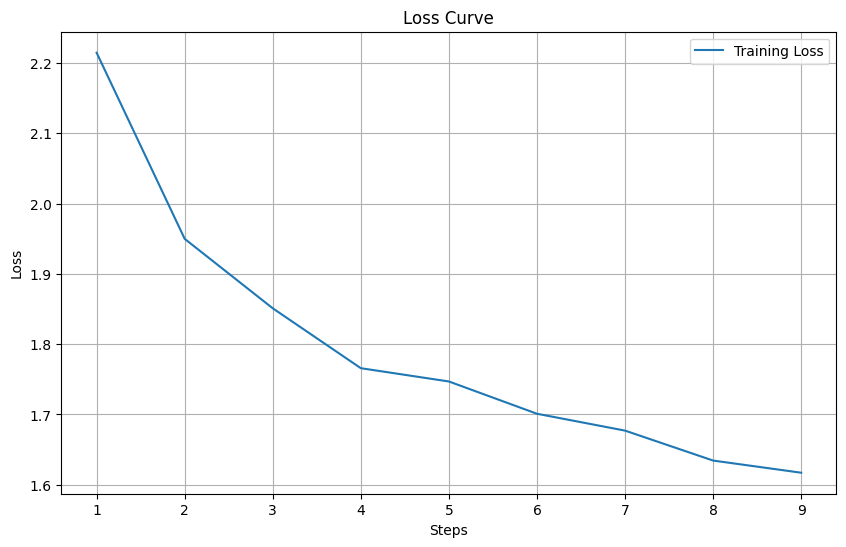

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model_dir = '/content/drive/MyDrive/Hybrid_Rec_Sys/best_model'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModel.from_pretrained(model_dir)

Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/Hybrid_Rec_Sys/best_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Content-based Filter**

In [ ]:
# Define the functions
def preprocess_news_info(dev_news):
    """
    Preprocess dev_news to filter out news_info entries with raw string length > 512.
    """
    dev_news = dev_news[dev_news['news_info'].str.len() < 512]
    return dev_news.reset_index(drop=True)

def get_embeddings(texts, tokenizer, model, device="cuda"):
    """
    Get embeddings for a batch of sentences.
    """
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token embeddings
    return cls_embeddings

def calculate_batch_similarity(text1, batch_texts, tokenizer, model, device="cuda"):
    """
    Calculate similarities between a single text and a batch of other texts.
    """
    embedding1 = get_embeddings([text1], tokenizer, model, device)  # Embedding for the anchor sentence
    embedding2 = get_embeddings(batch_texts, tokenizer, model, device)  # Batch embeddings
    # Compute cosine similarity between text1 and all batch_texts
    similarities = torch.nn.functional.cosine_similarity(embedding1, embedding2).cpu().numpy()
    return similarities


In [ ]:
user_id = "U80234"
device = "cuda"
model.to(device)
user_history = dev_users[dev_users['user_id'] == user_id]['history'].values
history = user_history[0]

cbf_recs = {}

user_history_idx = 0
for id in history:
    all_sim = []
    row = dev_news[dev_news['news_id'] == id]
    if not row.empty:
        sub = row['sub_category'].values[0]
        info = row['news_info'].values[0]
        group = grouped_news[sub]
        info_group = [group[i]['news_info'] for i in range(len(group))]
        id_group = [group[i]['news_id'] for i in range(len(group))]
        title_group = [group[i]['title'] for i in range(len(group))]

        dataloader = DataLoader(info_group, batch_size=512, shuffle=False)
        for batch in dataloader:
            similarities = calculate_batch_similarity(info, list(batch), tokenizer, model, device)
            all_sim.extend(zip(id_group, similarities))

        # Get top 5 similar articles (excluding the first one, which might be the article itself)
        top = sorted(all_sim, key=lambda x: x[1], reverse=True)[1]
        # print(top)
        # # Print base article info
        # print(user_history_idx)
        # print("Article ID:", id)
        # print("Title:", row['title'].values[0])
        # print("Top 5 Most Relevant Articles:")
        # Print each of the top 5 recommended articles with their ID, info, and similarity score
        rec_id = top[0]
        sim_score = top[1]
        rec_info = dev_news[dev_news['news_id'] == rec_id]['news_info'].values[0]
        rec_title = title_group[idx]
        cbf_recs[rec_id] = rec_title
        print(f"ID: {rec_id}, Title: {rec_title}, Similarity: {sim_score:.4f}")
    user_history_idx += 1


ID: N64240, Title: All the Things You Didn't Know About 'The Crown', Similarity: 0.7984
ID: N7232, Title: Ikea US president backpedals on meeting parents of children killed by recalled dressers, Similarity: 0.8729
ID: N56518, Title: 'Bachelor's Amanda Stanton Is Dating 'Rich Kids of Beverly Hills' Star Brendan Fitzpatrick, Similarity: 0.9430
ID: N49564, Title: Ikea US president backpedals on meeting parents of children killed by recalled dressers, Similarity: 0.7939
ID: N2028, Title: More store closings coming: The list of retailers closing locations in 2019, Similarity: 0.8573
ID: N24566, Title: Trying to Make a Ram 3500 as Quick as a Viper Requires Some Disassembly, Similarity: 0.9031
ID: N59742, Title: 'Bachelor's Amanda Stanton Is Dating 'Rich Kids of Beverly Hills' Star Brendan Fitzpatrick, Similarity: 0.8804
ID: N50456, Title: Celebrities at their Hollywood hand and footprint ceremonies, Similarity: 0.8891
ID: N26262, Title: Louisville's own Jennifer Lawrence ties the knot in a p

**Collaborative Filtering**

In [ ]:
group_users_by_news = {}
user_scores = {}

for _, row in dev_users.iterrows():
    user_id = row["user_id"]
    his_list = row["history"]

    if user_id not in user_scores:
        user_scores[user_id] = 0

    for his in his_list:
        if his not in group_users_by_news:
            group_users_by_news[his] = set()
        group_users_by_news[his].add(user_id)

In [ ]:



def get_user_rec(user, tokenizer, model, group_users_by_news, user_scores):

  def calculate_scores(user_id_to_set):
    for id in user_id_to_set:
      user_scores[id] = 1

    scores_by_his = {}
    for his, user_ids in group_users_by_news.items():
        scores_by_his[his] = sum(user_scores[user_id] for user_id in user_ids)

    sorted_scores = sorted(scores_by_his.items(), key=lambda x: -x[1])

    for id in user_id_to_set:
      user_scores[id] = 0

    return dict(list(scores_by_his.items())[:5])

  def get_score(news):
    if news not in group_users_by_news:
        return {}
    user_ids = group_users_by_news[news]
    return calculate_scores(user_ids)


  history = user["history"]
  top = defaultdict(int)
  for his in history:
    scores = get_score(his)

    for news, score in scores.items():
      top[news] += score

  sorted_top = dict(sorted(top.items()))
  if len(sorted_top) > 10:
    return dict(list(sorted_top.items())[:10])
  else:
    return sorted_top

In [ ]:
sample = dev_users.iloc[0]

cf_recs = get_user_rec(sample, tokenizer, model, group_users_by_news, user_scores)

**Combining both filters**

In [ ]:
for news_id in sample['history']:
    title = dev_news.loc[dev_news['news_id'] == news_id, 'title'].values

    if title:
        print(f"News ID: {news_id}, Title: {title[0]}")
    else:
        print(f"News ID: {news_id} not found in dev_news")

News ID: N55189, Title: 'Wheel Of Fortune' Guest Delivers Hilarious, Off The Rails Introduction
News ID: N46039, Title: Hard Rock Hotel New Orleans collapse: Former site engineer weighs in
News ID: N51741, Title: Felicity Huffman begins prison sentence for college admissions scam
News ID: N53234, Title: Outer Banks storms unearth old shipwreck from 'Graveyard of the Atlantic'
News ID: N11276, Title: Tiffany's is selling a holiday advent calendar for $112,000
News ID: N264, Title: This restored 1968 Winnebago is beyond adorable
News ID: N40716, Title: Lori Loughlin Is 'Absolutely Terrified' After Being Hit With New Charge
News ID: N28088, Title: Bruce Willis brought Demi Moore to tears after reading her book
News ID: N43955, Title: Celebrity kids then and now: See how they've grown
News ID: N6616, Title: Felicity Huffman Smiles as She Begins Community Service Following Prison Release
News ID: N47686, Title: Queen Elizabeth Finally Had Her Dream Photoshoot, Thanks to Royal Dresser Angela

News ID: N59742, Title: Milania Giudice Says She'll See Dad Joe 'Soon' After He Leaves ICE Custody
News ID: N64240, Title: P.K. Subban Gives Inside Look at New Life in New Jersey with Fiancée Lindsey Vonn in YouTube Video
News ID: N49564, Title: Halloween snow prompts Milwaukee-area communities to reschedule planned trick-or-treat hours
News ID: N27079, Title: Donald Trump Jr slams The View Host Sunny Hostin by asking what it's like to be paid by a network that 'protected pedophile - rapist Jeffrey Epstein' in war of words on Twitter
News ID: N37822, Title: Market car bomb kills at least 13 near Syrian-Turkish border


In [ ]:
import random

sampled_news_ids = random.sample(list(cbf_recs.keys()), min(5, len(cbf_recs)))

for news_id in sampled_news_ids:
    title = dev_news.loc[dev_news['news_id'] == news_id, 'title'].values

    if title:
        print(f"News ID: {news_id}, Title: {title[0]}")
    else:
        print(f"News ID: {news_id} not found in dev_news")

print("======================")


for news_id in cf_recs.keys():
    title = dev_news.loc[dev_news['news_id'] == news_id, 'title'].values

    if title:
        print(f"News ID: {news_id}, Title: {title[0]}")
    else:
        print(f"News ID: {news_id} not found in dev_news")


News ID: N49564, Title: Halloween snow prompts Milwaukee-area communities to reschedule planned trick-or-treat hours
News ID: N50456, Title: Demi Moore's daughter reveals her mother's battle with addiction was like 'a monster came'
News ID: N37822, Title: Market car bomb kills at least 13 near Syrian-Turkish border
News ID: N7232, Title: In photos: California Wildfires
News ID: N56518, Title: Felicity Huffman Released From Prison Before End of 14-Day Sentence
News ID: N11276, Title: Tiffany's is selling a holiday advent calendar for $112,000
News ID: N46039, Title: Hard Rock Hotel New Orleans collapse: Former site engineer weighs in
News ID: N51741, Title: Felicity Huffman begins prison sentence for college admissions scam
News ID: N53234, Title: Outer Banks storms unearth old shipwreck from 'Graveyard of the Atlantic'
News ID: N55189, Title: 'Wheel Of Fortune' Guest Delivers Hilarious, Off The Rails Introduction
